## Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Cargamos las librerías necesarias
import math
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
#import shap

#from src.visualization.metrics_summary import cross_val_reg, gam_cross_val_reg, err_hist, pred_hist, plot_residuo, plot_corr_matrix
import os

In [5]:
os.chdir('..')

In [6]:
# Cargamos datos con SQR
perfiles_sqr = pd.read_parquet('data/processed/perfiles_sqr_filtrado.parquet')
perfiles_sqr.reset_index(drop=True, inplace=True) # reseteamos el índice

In [8]:
perfiles_sqr['IMC'] = perfiles_sqr['peso'] / (perfiles_sqr['altura']/100)**2
perfiles_sqr['IMC_cat'] = pd.cut(perfiles_sqr['IMC'], bins=[0, 25, 30, 50],
                                include_lowest=True,labels=['Normal', 'Sobrepeso', 'Obesidad'])

In [7]:
# Separamos las presiones para tenerlas como 6 variables
cols = ['PresPos1', 'PresPos2', 'PresPos3', 'PresPos4', 'PresPos5', 'PresPos6']
rows = range(len(perfiles_sqr[['presiones']]))
df_pres_split = pd.DataFrame(columns=cols, index=rows)

for j in range(len(perfiles_sqr[['presiones']])):
    pres_j = perfiles_sqr.loc[j,'presiones']
    pres_j_split = [pres_j[i:i + 1] for i in range(0, len(pres_j), 1)]
    df_pres_split.iloc[j, :] = pres_j_split
# juntamos todo
perfiles_sqr = pd.concat([perfiles_sqr, df_pres_split], axis=1)
perfiles_sqr.head()

NameError: name 'df_pres' is not defined

In [11]:
### Creamos cada uno de los dataframes
datos1 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos2 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos3 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Obese')]
datos4 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos5 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos6 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Obese')]
datos7 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos8 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos9 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Obese')]
datos10 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos11 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos12 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Obese')]

In [13]:
## Preparamos datasets para rf
X1 = datos1[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y1 = datos1['sqr']

X2 = datos2[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y2 = datos2['sqr']

X3 = datos3[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y3 = datos3['sqr']

X4 = datos4[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y4 = datos4['sqr']

X5 = datos5[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y5 = datos5['sqr']

X6 = datos6[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y6 = datos6['sqr']

X7 = datos7[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y7 = datos7['sqr']

X8 = datos8[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y8 = datos8['sqr']

X9 = datos9[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y9 = datos9['sqr']

X10 = datos10[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y10 = datos10['sqr']

X11 = datos11[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y11 = datos11['sqr']

X12 = datos12[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y12 = datos12['sqr']

### Data1

In [37]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf1 = rfr.fit(X1, y1)


In [191]:
#perm = PermutationImportance(rf1, random_state=42, n_iter=10).fit(X1, y1)
#eli5.show_weights(perm, feature_names = X1.columns.tolist())

In [39]:
#rf1.feature_importances_

array([0.31136481, 0.08507876, 0.21848482, 0.21696197, 0.12316309,
       0.04494656])

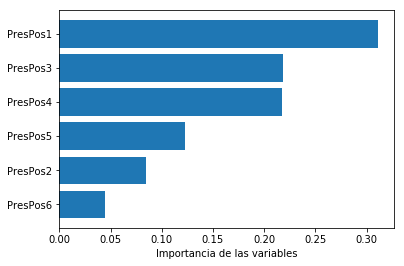

In [214]:
sorted_idx = rf1.feature_importances_.argsort()
plt.barh(X1.columns[sorted_idx], rf1.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

In [266]:
## Mejora 
aa = pd.DataFrame(datos1.groupby('PresPos1').agg({'sqr': ['mean']}))
maxim = aa[:].values.max()
#mejora
m1=100*(maxim-datos1['sqr'].mean())/datos1['sqr'].mean()
m1

12.908924189145464

In [267]:
aa

,sqr
,mean
PresPos1,
0,68.338024
1,78.946405
2,75.666971
3,81.036069
5,64.650202


In [268]:
maxim

81.0360693772316

En la categoría Male, con posición lateral y un IMC normal, si el tubo 1 se pone al valor óptimo de presión 4, la media del SQR mejora en un 12.9%.


### Dataset2

In [41]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf2 = rfr.fit(X2, y2)

In [42]:
rf2.feature_importances_

array([0.13027384, 0.1021189 , 0.26146373, 0.11934336, 0.20127616,
       0.18552399])

Text(0.5, 0, 'Random Forest Feature Importance')

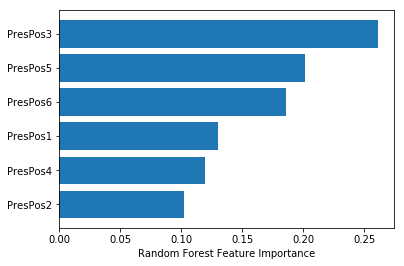

In [43]:
sorted_idx = rf2.feature_importances_.argsort()
plt.barh(X2.columns[sorted_idx], rf2.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [217]:
## Mejora 
aa = pd.DataFrame(datos2.groupby('PresPos3').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m2=100*(maxim-datos2['sqr'].mean())/datos2['sqr'].mean()
m2

9.15440800257279

In [218]:
aa

,sqr
,mean
PresPos3,
0,68.504511
1,56.662330
2,68.682282
3,73.388055
5,79.152724


In [219]:
maxim

79.15272403854647

En esta categoría, si el tubo 3 se pone al valor óptimo de presión 6, la media del SQR mejora en un 9.15%.

### Dataset3

In [44]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf3 = rfr.fit(X3, y3)

In [45]:
rf3.feature_importances_

array([0.09773588, 0.15182559, 0.10370436, 0.10887578, 0.29096538,
       0.24689302])

Text(0.5, 0, 'Random Forest Feature Importance')

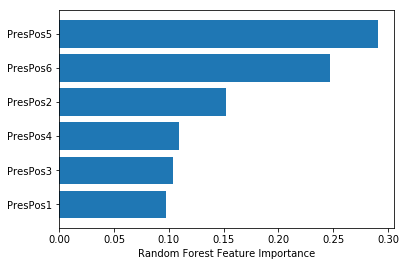

In [46]:
sorted_idx = rf3.feature_importances_.argsort()
plt.barh(X3.columns[sorted_idx], rf3.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [220]:
## Mejora 
aa = pd.DataFrame(datos3.groupby('PresPos5').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m3=100*(maxim-datos3['sqr'].mean())/datos3['sqr'].mean()
m3

12.469329982735772

In [221]:
aa

,sqr
,mean
PresPos5,
0,71.014647
1,61.567073
2,78.654485
3,73.620785
4,64.724318
5,68.050307


In [222]:
maxim

78.65448506262625

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 3, la media del SQR mejora en un 12.47%.

### Dataset4

In [47]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf4 = rfr.fit(X4, y4)

In [48]:
rf4.feature_importances_

array([0.28288351, 0.11446926, 0.26645536, 0.14023025, 0.03913156,
       0.15683007])

Text(0.5, 0, 'Random Forest Feature Importance')

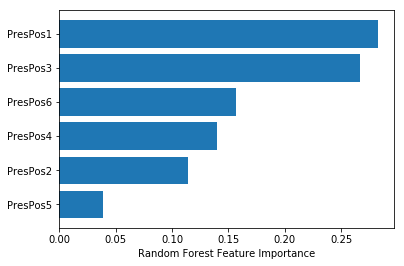

In [49]:
sorted_idx = rf4.feature_importances_.argsort()
plt.barh(X4.columns[sorted_idx], rf4.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [269]:
## Mejora 
aa = pd.DataFrame(datos4.groupby('PresPos1').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim1 = aa[:].values.max()

aa1 = pd.DataFrame(datos4.groupby('PresPos3').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim2 = aa1[:].values.max()

maxim = np.array([maxim1,maxim2]).mean()

#mejora
m4=100*(maxim1-datos4['sqr'].mean())/datos4['sqr'].mean()
m4

m4a=100*(maxim2-datos4['sqr'].mean())/datos4['sqr'].mean()
m4a

21.044334998591214

In [230]:
aa1

,sqr
,mean
PresPos3,
0,74.846309
1,68.079804
2,73.593853
3,77.327731
4,90.585306
5,87.512646


In [231]:
maxim2

90.58530585651422

In [270]:
aa

,sqr
,mean
PresPos1,
0,75.527703
1,73.238535
2,55.237353
3,92.370893
5,81.165931


In [271]:
maxim1

92.37089253266441

En esta categoría, si el tubo 1 se pone al valor óptimo de presión 4, la media del SQR mejora en un 23.43%. Si el tubo 3 se pone al valor óptimo 5, la media del SQR mejora en un 21.04%.

### Dataset5

In [50]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf5 = rfr.fit(X5, y5)

In [51]:
rf5.feature_importances_

array([0.16934113, 0.07389726, 0.25676282, 0.06061828, 0.26503993,
       0.17434059])

Text(0.5, 0, 'Random Forest Feature Importance')

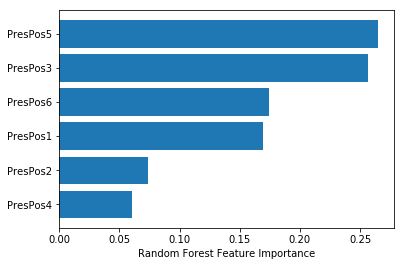

In [52]:
sorted_idx = rf5.feature_importances_.argsort()
plt.barh(X5.columns[sorted_idx], rf5.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [234]:
## Mejora 
aa = pd.DataFrame(datos5.groupby('PresPos5').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m5=100*(maxim-datos5['sqr'].mean())/datos5['sqr'].mean()
m5

17.644378944620254

In [235]:
aa

,sqr
,mean
PresPos5,
0,78.466655
2,67.377170
3,66.366250
4,75.080812
5,56.857391


In [236]:
maxim

78.46665478136494

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 1, la media del SQR mejora en un 17.64%. 

### Dataset6

In [53]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf6 = rfr.fit(X6, y6)

In [54]:
rf6.feature_importances_

array([0.29770743, 0.12689123, 0.06249734, 0.14299976, 0.22426724,
       0.145637  ])

Text(0.5, 0, 'Random Forest Feature Importance')

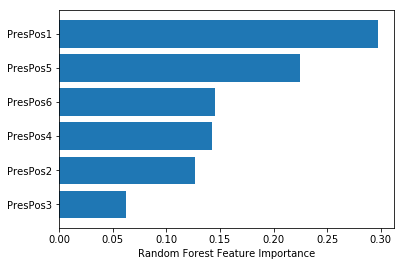

In [55]:
sorted_idx = rf6.feature_importances_.argsort()
plt.barh(X6.columns[sorted_idx], rf6.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [237]:
## Mejora 
aa = pd.DataFrame(datos6.groupby('PresPos1').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m6=100*(maxim-datos6['sqr'].mean())/datos6['sqr'].mean()
m6

10.945333862518975

In [238]:
aa

,sqr
,mean
PresPos1,
0,49.654943
1,80.205710
2,67.741054
3,70.990995
4,72.540510


In [239]:
maxim

80.20570984340979

En esta categoría, si el tubo 1 se pone al valor óptimo de presión 2, la media del SQR mejora en un 10.95%. 

### Dataset7

In [56]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf7 = rfr.fit(X7, y7)

In [57]:
rf7.feature_importances_

array([0.15085975, 0.15676559, 0.19918959, 0.17390635, 0.13228179,
       0.18699693])

Text(0.5, 0, 'Random Forest Feature Importance')

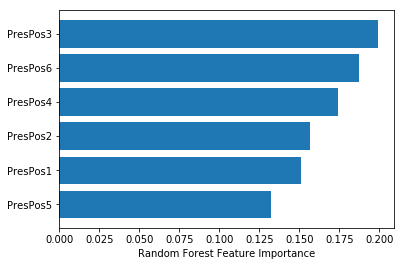

In [58]:
sorted_idx = rf7.feature_importances_.argsort()
plt.barh(X7.columns[sorted_idx], rf7.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [240]:
## Mejora 
aa = pd.DataFrame(datos7.groupby('PresPos3').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m7=100*(maxim-datos7['sqr'].mean())/datos7['sqr'].mean()
m7

15.346519979582952

In [241]:
aa

,sqr
,mean
PresPos3,
0,81.486037
1,79.313478
2,72.801638
3,85.662520
4,72.036496
5,75.737180


In [242]:
maxim

85.66251969021654

En esta categoría, si el tubo 3 se pone al valor óptimo de presión 4, la media del SQR mejora en un 15.35%. 

### Dataset8

In [59]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf8 = rfr.fit(X8, y8)

In [60]:
rf8.feature_importances_

array([0.31272036, 0.16616391, 0.127514  , 0.13589367, 0.11061861,
       0.14708945])

Text(0.5, 0, 'Random Forest Feature Importance')

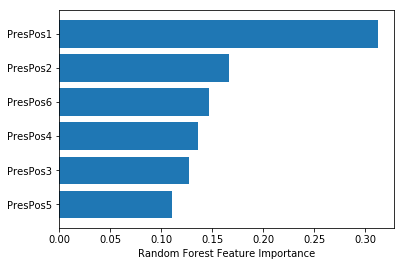

In [63]:
sorted_idx = rf8.feature_importances_.argsort()
plt.barh(X8.columns[sorted_idx], rf8.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [244]:
## Mejora 
aa = pd.DataFrame(datos8.groupby('PresPos1').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m8=100*(maxim-datos8['sqr'].mean())/datos8['sqr'].mean()
m8

14.621260864001442

In [245]:
aa

,sqr
,mean
PresPos1,
0,73.548181
1,73.743883
2,85.188195


In [246]:
maxim

85.18819524021652

En esta categoría, si el tubo 1 se pone al valor óptimo de presión 3, la media del SQR mejora en un 14.62%.

### Dataset9

In [64]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf9 = rfr.fit(X9, y9)

In [65]:
rf9.feature_importances_

array([0.24421458, 0.05445123, 0.11047262, 0.18972399, 0.24827642,
       0.15286116])

Text(0.5, 0, 'Random Forest Feature Importance')

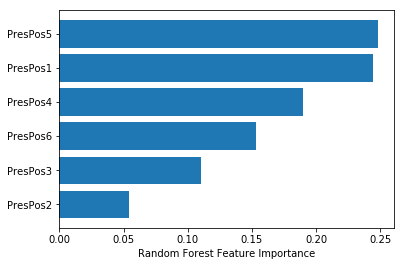

In [66]:
sorted_idx = rf9.feature_importances_.argsort()
plt.barh(X9.columns[sorted_idx], rf9.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [272]:
## Mejora 
aa1 = pd.DataFrame(datos9.groupby('PresPos5').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim1 = aa1[:].values.max()

aa2 = pd.DataFrame(datos9.groupby('PresPos1').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim2 = aa2[:].values.max()


maxim = np.array([maxim1,maxim2]).mean()

#mejora
m9=100*(maxim-datos9['sqr'].mean())/datos9['sqr'].mean()
m9

5.342106668691785

In [251]:
aa2

,sqr
,mean
PresPos1,
0,70.792553
1,64.574961
2,70.444614
3,55.096396
5,64.758262


In [252]:
maxim2

70.79255326825839

In [273]:
aa1

,sqr
,mean
PresPos5,
0,66.169084
1,67.018003
2,76.471333
3,57.461983
5,64.758262


In [274]:
maxim1

76.47133262796942

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 3, la media del SQR mejora en un 13.79%. Si el tubo 1 se pone al valor óptimo de presión 1, la media del SQR mejora en un 5.34%.

### Dataset10

In [67]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf10 = rfr.fit(X10, y10)

In [68]:
rf10.feature_importances_

array([0.08886147, 0.15619339, 0.10118441, 0.09081646, 0.46146436,
       0.1014799 ])

Text(0.5, 0, 'Random Forest Feature Importance')

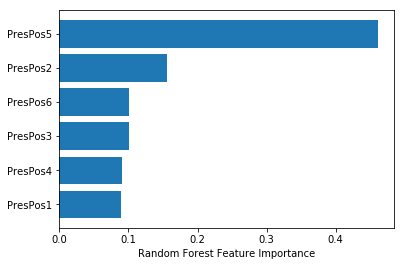

In [69]:
sorted_idx = rf10.feature_importances_.argsort()
plt.barh(X10.columns[sorted_idx], rf10.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [256]:
## Mejora 
aa = pd.DataFrame(datos10.groupby('PresPos5').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m10=100*(maxim-datos10['sqr'].mean())/datos10['sqr'].mean()
m10

11.576938590388075

In [257]:
aa

,sqr
,mean
PresPos5,
0,79.711485
1,69.145666
2,73.257843
3,64.300544
4,77.106128
5,74.426356


In [258]:
maxim

79.71148451105992

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 1, la media del SQR mejora en un 11.58%.

### Dataset11

In [70]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf11 = rfr.fit(X11, y11)

In [71]:
rf11.feature_importances_

array([0.03357709, 0.04821366, 0.21027254, 0.57968792, 0.02951941,
       0.09872939])

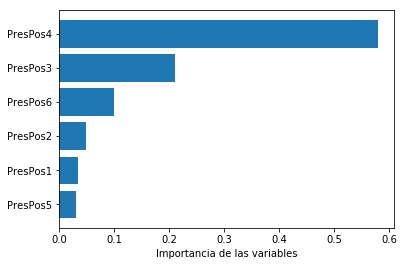

In [190]:
sorted_idx = rf11.feature_importances_.argsort()
plt.barh(X11.columns[sorted_idx], rf11.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

In [259]:
## Mejora 
aa = pd.DataFrame(datos11.groupby('PresPos4').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m11=100*(maxim-datos11['sqr'].mean())/datos11['sqr'].mean()
m11

5.36916481032439

In [260]:
aa

,sqr
,mean
PresPos4,
1,36.319524
2,59.424409
3,75.396736


In [261]:
maxim

75.39673578391077

En esta categoría, si el tubo 4 se pone al valor óptimo de presión 4, la media del SQR mejora en un 5.37%.

### Dataset12

In [73]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf12 = rfr.fit(X12, y12)

In [74]:
rf12.feature_importances_

array([0.11803541, 0.10439079, 0.17952168, 0.13027291, 0.42072773,
       0.04705149])

Text(0.5, 0, 'Random Forest Feature Importance')

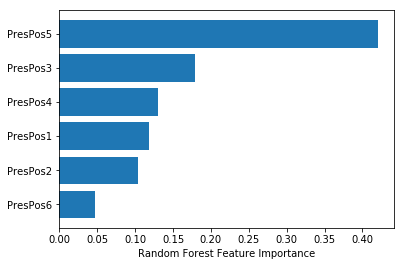

In [75]:
sorted_idx = rf12.feature_importances_.argsort()
plt.barh(X12.columns[sorted_idx], rf12.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [263]:
## Mejora 
aa = pd.DataFrame(datos12.groupby('PresPos5').agg({'sqr': ['mean']}))
#aa.reset_index(drop=True, inplace = True)
maxim = aa[:].values.max()
#mejora
m12=100*(maxim-datos12['sqr'].mean())/datos12['sqr'].mean()
m12

7.3494083946822055

In [264]:
aa

,sqr
,mean
PresPos5,
0,44.548415
2,73.489585
3,71.953325
5,64.910756


In [265]:
maxim

73.48958480156094

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 3, la media del SQR mejora en un 7.35%.